<a href="https://colab.research.google.com/github/sardarmonsoorsait/Crossroad/blob/master/face_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import cv2
import numpy as np
import dlib
 
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index
 
img = cv2.imread("/content/drive/MyDrive/face_project/train/ajith/Ajith_Mankatha_750X500.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
img2 = cv2.imread("/content/drive/MyDrive/face_swap/1513236.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 
 

mask = np.zeros_like(img_gray)

 
# Loading Face landmarks detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/face_swap/shape_predictor_68_face_landmarks.dat")
img2_new_face = np.zeros_like(img2)

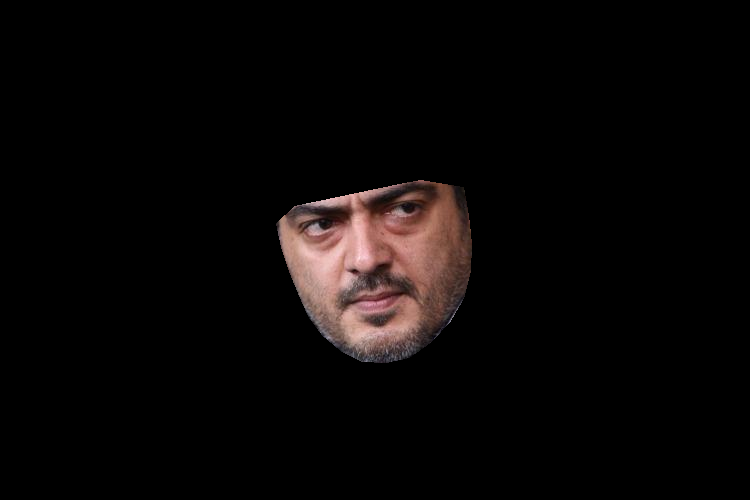

In [68]:
# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))
 
        #cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
 
    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    #cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)
 
    face_image_1 = cv2.bitwise_and(img, img, mask=mask)
 
 
    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)
 
    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
 
        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)
 
        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)
 
        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)
 
        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)
cv2_imshow(face_image_1)

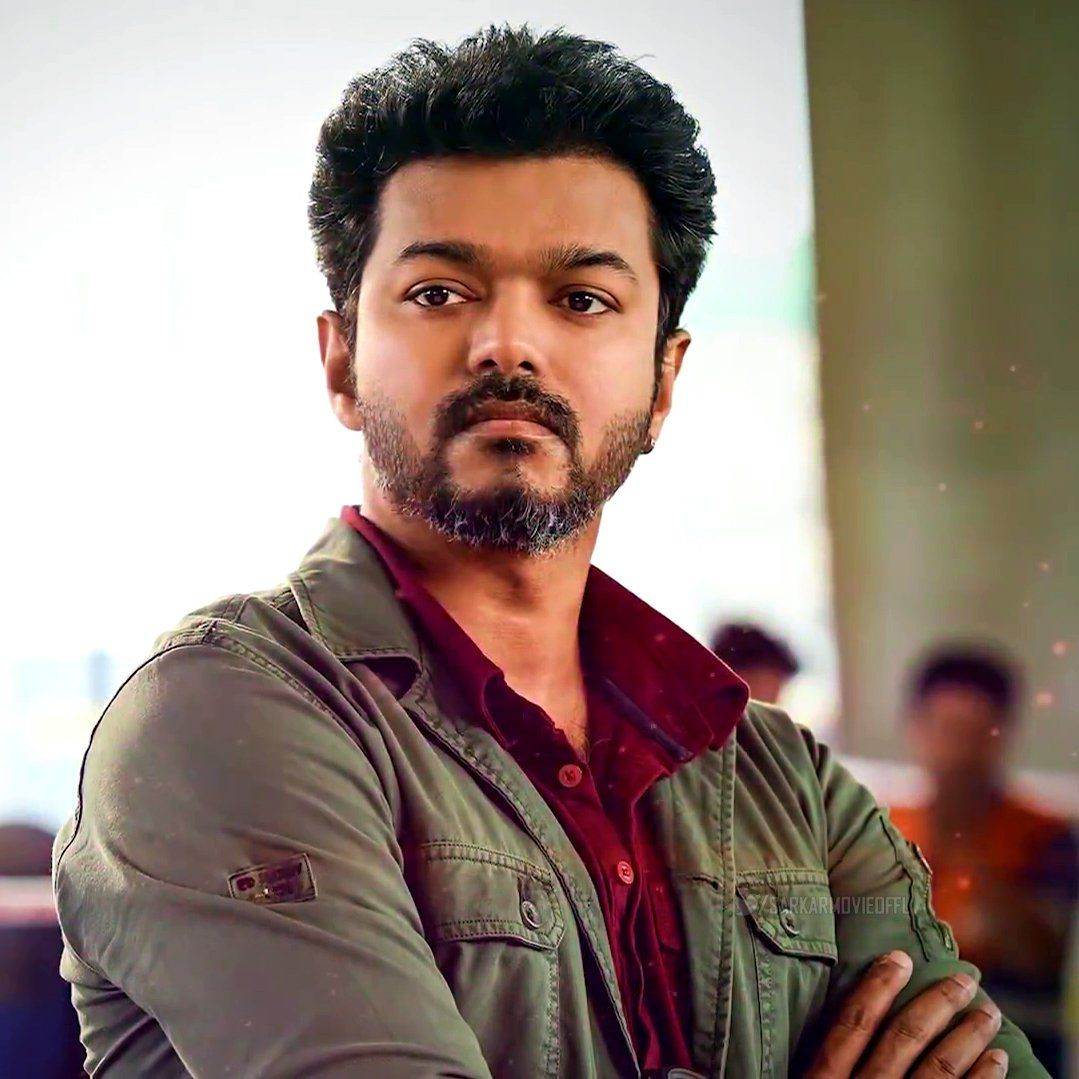

In [69]:
# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))
        #cv2.circle(img2, (x, y), 3, (0, 255, 0), -1)
#cv2.fillConvexPoly(mask,convexhull2,255)

cv2_imshow(img2)

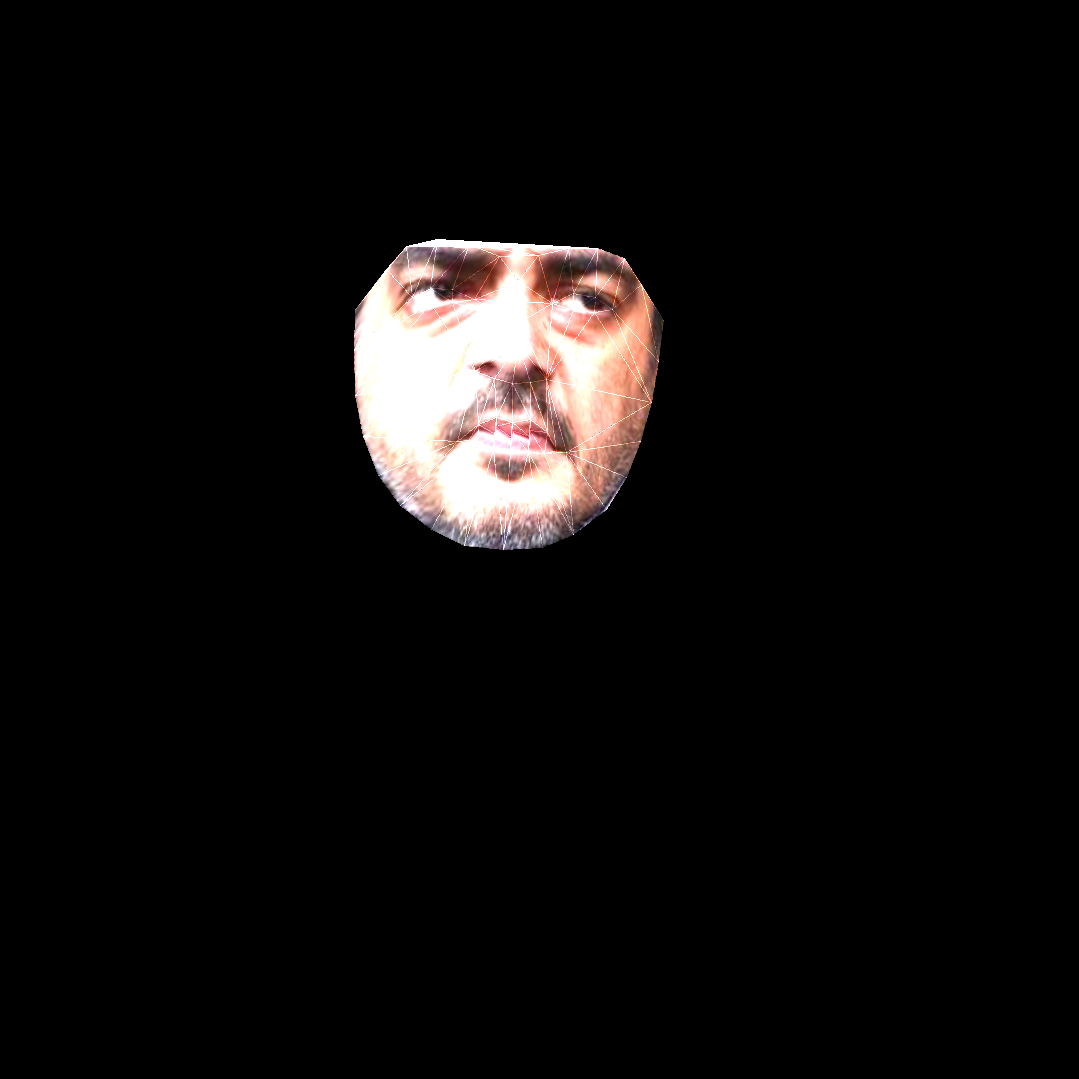

In [71]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)
 
    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)
 
    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                      [tr1_pt2[0] - x, tr1_pt2[1] - y],
                      [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
 
    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)
    cropped_triangle = cv2.bitwise_and(cropped_triangle, cropped_triangle,
                                       mask=cropped_tr1_mask)
 
 
    #cv2.line(img, tr1_pt1, tr1_pt2, (0, 0, 255), 2)
    #cv2.line(img, tr1_pt3, tr1_pt2, (0, 0, 255), 2)
    #cv2.line(img, tr1_pt1, tr1_pt3, (0, 0, 255), 2)
    #cv2_imshow(cropped_triangle) 
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2
    cropped_triangle2 = img2[y: y + h, x: x + w]
    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
    cropped_triangle2 = cv2.bitwise_and(cropped_triangle2, cropped_triangle2,
                                        mask=cropped_tr2_mask)

    #cv2.line(img2, tr2_pt3, tr2_pt2, (0, 0, 255), 2)
    #cv2.line(img2, tr2_pt1, tr2_pt3, (0, 0, 255), 2)
    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)

    M = cv2.getAffineTransform(points, points2)

    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)
    # Reconstructing destination face
    
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area
    #img2_new_face[y:y+h,x:x+w] = traingle_area
cv2_imshow(img2_new_face)

In [72]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)
 
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)
#cv2_imshow(img2_head_noface)

In [73]:
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.MIXED_CLONE)


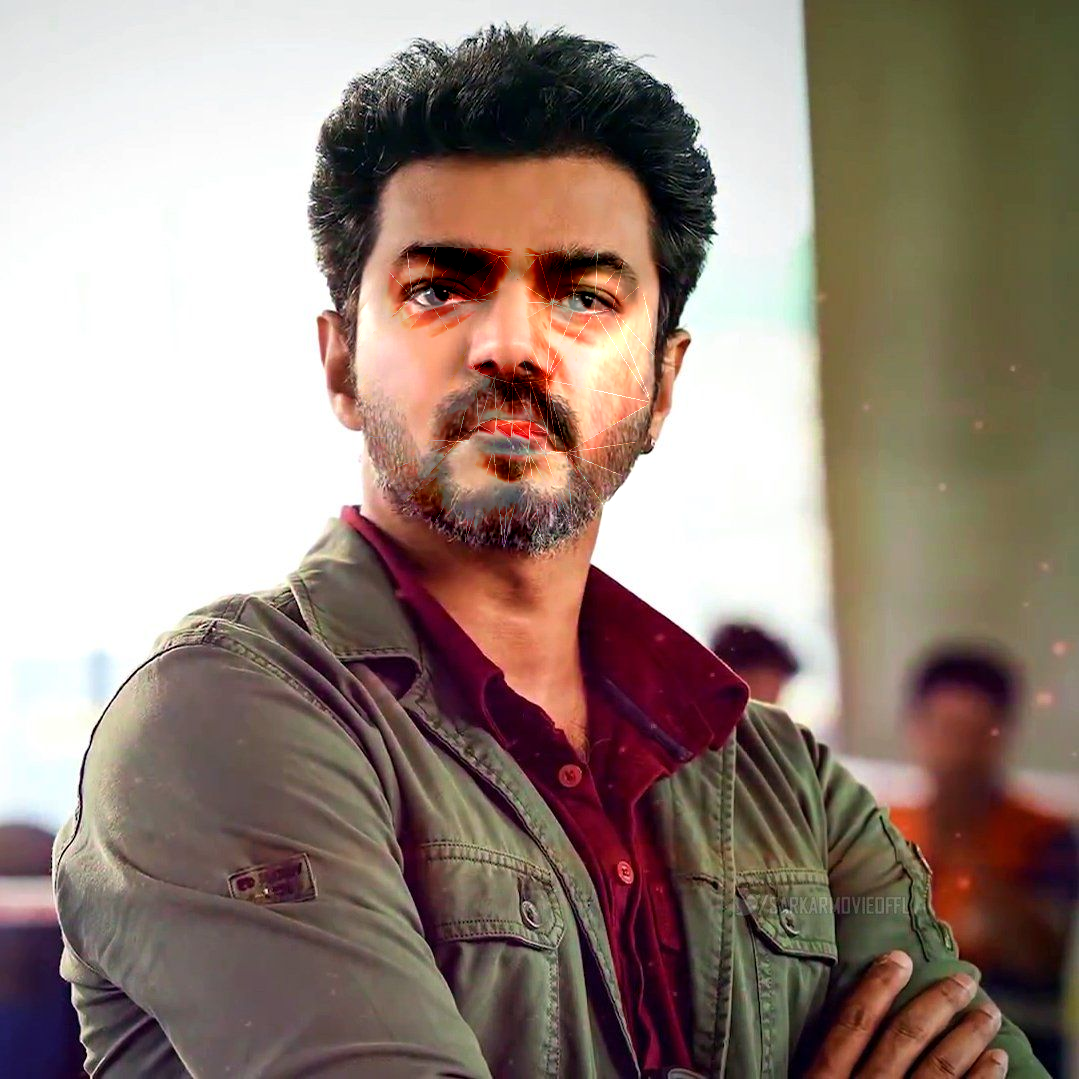

In [74]:
from google.colab.patches import cv2_imshow
cv2_imshow(seamlessclone)